# Pylops-distributed - Solvers

In this notebook we investigate the use of pylops-distributed CG and CGLS solvers with distributed operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import dask
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse.linalg.interface import MatrixLinearOperator, aslinearoperator 
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from dask import persist
from dask.distributed import Client, LocalCluster, performance_report

In [2]:
os.getenv('OMP_NUM_THREADS'), os.getenv('MKL_NUM_THREADS'), os.getenv('OPENBLAS_NUM_THREADS')

('1', '1', '1')

In [3]:
#nchunks = [2, 1]
#nchunks = [2, 2]
nchunks = [4, 4]

#client = pylops_distributed.utils.backend.dask(processes=True, threads_per_worker=1, n_workers=4)
#client = Client() # same as processes=True

client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1, n_workers=4)
client

Client Scheduler: inproc://10.0.0.156/5266/1 Dashboard: http://10.0.0.156:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### CG for square systems

Let's just try out the solver using numpy inputs (matrix and vector). As da.xx is never explicitely invoked when ``compute=False`` and ``client=None`` the solver will simply operate on numpy arrays

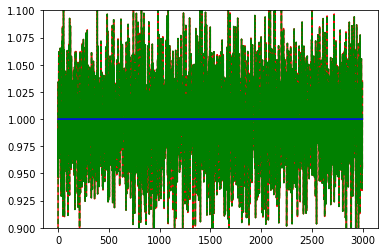

In [4]:
n = 3000
niter = 1000 # premature stop... # n * 2 to convergence
x = np.ones(n)

np.random.seed(0)
A = np.random.randn(n, n)
A = np.dot(A.T, A)
#print('eigs', np.linalg.eig(A)[0])

Aop = MatrixLinearOperator(A)
#Aop = aslinearoperator(A)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, tol=0, maxiter=niter)[0]
xinv = pylops_distributed.optimization.cg.cg(Aop, y, np.zeros_like(x), tol=0, niter=niter)[0]
#print(xinv_sp)
#print(xinv)

plt.figure()
plt.plot(xinv_sp,'r', xinv, '--g', x,'b')
plt.ylim(0.9, 1.1);

Let's now apply the forward using the LinearOperator interface

In [5]:
Ada = da.from_array(A, chunks=(n//nchunks[0], n//nchunks[1])).persist()  # move the data to the workers once
x = da.ones(n) #, chunks=(n//nchunks[1]))
x0 = da.zeros(n) #, chunks=(n//nchunks[1]))

Aop = MatrixLinearOperator(A)
Adaop = pylops_distributed.MatrixMult(Ada, compute=(False, False))
Ada1op = pylops_distributed.MatrixMult(Ada, compute=(True, True))

# both of these take and return a numpy array
print(Aop.matvec(np.ones(n)), Ada1op.matvec(np.ones(n)))

# takes and returns a dask array
print(Adaop.matvec(np.ones(n)))

[-1913.40090063 -3343.24939275  -423.66494977 ...   477.63396435
   134.07361261  1897.29151543] [-1913.40090063 -3343.24939275  -423.66494977 ...   477.63396435
   134.07361261  1897.29151543]
dask.array<sum-aggregate, shape=(3000,), dtype=float64, chunksize=(750,), chunktype=numpy.ndarray>


In [6]:
Ada

dask.array<array, shape=(3000, 3000), dtype=float64, chunksize=(750, 750), chunktype=numpy.ndarray>

And the inverse problem with different approches when it comes to the use of dask

In [7]:
niter = 100

y = Aop * np.ones(n)
yy = Adaop * da.ones(n)

# scipy
xinv_sp = cg(Aop, y, maxiter=niter)[0]

# dask with compute at each iter
xinv = pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, compute=True)[0]
# dask with persist at each iter
xinv1 = pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, client=client)[0]
# dask with all graph computed in one go
xinv2 = pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter)[0]
# dask for only the matvec operation (anything else numpy)
xinv3 = pylops_distributed.optimization.cg.cg(Ada1op, y, np.zeros(n), tol=0, niter=niter)[0]

print(xinv_sp)
print(xinv)
print(xinv1.compute())
print(xinv2.compute())
print(xinv3)

[1.02463913 0.90384892 0.95533622 ... 0.9619385  0.97546219 1.11433985]
[1.02463913 0.90384892 0.95533622 ... 0.9619385  0.97546219 1.11433985]
[1.02463913 0.90384892 0.95533622 ... 0.9619385  0.97546219 1.11433985]
[1.02463913 0.90384892 0.95533622 ... 0.9619385  0.97546219 1.11433985]
[1.02463913 0.90384892 0.95533622 ... 0.9619385  0.97546219 1.11433985]


In [8]:
#client.cancel(xinv1)
#client.cancel(xinv2)

In [9]:
# scipy
%timeit -n 1 -r 3 cg(Aop, y, maxiter=niter)[0]

588 ms ± 17.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [10]:
# dask with compute at each iter
#%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, compute=True)[0]

In [11]:
# dask with persist at each iter
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, client=client)[0].compute()

23.4 s ± 46.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
# dask with all graph computed in one go
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter)[0].compute()

7.7 s ± 60.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [13]:
# dask for only the matvec operation (anything else numpy)
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cg(Ada1op, y, np.zeros(n), tol=0, niter=niter)[0]

12.4 s ± 79.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [14]:
with performance_report(filename="dask-report-cg_compute.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, compute=True)[0]

In [15]:
with performance_report(filename="dask-report-cg_persist.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter, client=client)[0].compute()

In [16]:
with performance_report(filename="dask-report-cg_postponed.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, x0, tol=0, niter=niter)[0].compute()

In [17]:
with performance_report(filename="dask-report-cg_onlymatvec.html"):
    pylops_distributed.optimization.cg.cg(Ada1op, y, np.zeros(n), tol=0, niter=niter)[0]

### CGLS with sparse matrix

### CGLS for rectangular systems

In [18]:
n, m = 1000, 50
x = da.ones(m, chunks=(m//nchunks[1]))
x0 = da.zeros(m, chunks=(m//nchunks[1]))

A = np.random.randn(n, m)
Ada = da.from_array(A, chunks=(n//nchunks[0], m//nchunks[1]))
Aop = pylops_distributed.MatrixMult(Ada, compute=(False, False))
y = Aop * x

xinv = pylops_distributed.optimization.cg.cgls(Aop, y, x0, m)[0]
xinv.compute()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
#y.visualize(rankdir="LR")
#xinv.visualize(rankdir="LR")

In [20]:
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cgls(Aop, y, x0, tol=0, niter=20, compute=True)

9.66 s ± 44.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [21]:
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cgls(Aop, y, x0, tol=0, niter=20, client=client)[0].compute()

10.7 s ± 154 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [22]:
%timeit -n 1 -r 3 pylops_distributed.optimization.cg.cgls(Aop, y, x0, tol=0, niter=20)[0].compute()

7.13 s ± 81.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## LSQR scipy

In [23]:
import numpy as np
import dask.array as da
import pylops_distributed
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg.interface import MatrixLinearOperator

n, m = 100, 100

A = da.random.random((n, m), chunks=(n//nchunks[0], m//nchunks[1]))

# dask for everything (suboptimal as the solver is not written with dask 
#in mind and bring back to numpy here and there)
#Aop = pylops_distributed.MatrixMult(A)

# dask for only the matvec operation (anything else numpy)
Aop = MatrixLinearOperator(A)
Aop1 = pylops_distributed.MatrixMult(A, compute=(True, True))

y = Aop * np.ones(m)
xinv = lsqr(Aop1, y, iter_lim=n)[0]
y, xinv

(array([49.1663997 , 50.56491025, 46.33127647, 49.91828739, 52.6984893 ,
        55.47269824, 54.461011  , 52.8146886 , 48.5026307 , 40.83736659,
        45.85238495, 46.39221617, 49.76043088, 53.63444822, 49.7066871 ,
        53.99700797, 45.55617584, 48.09187034, 48.2602893 , 49.9416108 ,
        52.82253291, 47.7674436 , 50.10957465, 55.37026497, 52.80309789,
        48.1086633 , 50.16474483, 50.89657529, 47.04575089, 53.82232973,
        48.26146657, 52.57065493, 47.23123338, 50.71375005, 49.81424411,
        46.81939422, 50.03993458, 55.20772363, 47.13274771, 53.26142395,
        45.3254019 , 51.07767304, 49.87357891, 52.15761628, 47.63258035,
        49.54250868, 48.12370408, 51.44552688, 47.35080766, 48.34678681,
        51.55254009, 52.59149541, 45.20839298, 48.7127196 , 57.0026704 ,
        45.35623158, 46.63943708, 47.36902913, 51.22398442, 53.34852573,
        49.54704973, 56.50673386, 49.47172904, 47.59244381, 53.38177431,
        53.96599057, 42.58664758, 48.64074614, 46.8

In [24]:
%%time 
xinv = lsqr(Aop, y, iter_lim=n)[0]

CPU times: user 33.8 s, sys: 2.46 s, total: 36.3 s
Wall time: 35 s


In [25]:
%%time 
xinv = lsqr(Aop1, y, iter_lim=n)[0]

CPU times: user 32.9 s, sys: 2.44 s, total: 35.3 s
Wall time: 34.1 s


In [26]:
with performance_report(filename="dask-report-lsqr_MatrixLinearOperator.html"):
    lsqr(Aop, y, iter_lim=n)[0]

In [ ]:
with performance_report(filename="dask-report-lsqr_pylopsMatrixMult.html"):
    lsqr(Aop1, y, iter_lim=n)[0]

In [ ]:
client.close()